# Barest Soil 

### Fei Zhang @Geoscience Australia

Last Updated  Sept 2016

## Introduction

Find the barest soil Earth observations from time series analysis. The result data  will be used as input for the mineral resources uncover project:  machine-learning application.

Here are the centre point locations for 3 study aread with different vegetation/bareness relationships;

1. Edge of fire scar (NT) 19:36:10.24S//132:34:55.72E

2. Farming land (crops (green and fallow paddocks - Western NSW)30:5:45.33S/148:11:29.75E

3. Woodland (remain greenish most of the time - the understory should change in response to seasonal drying out)22:52:35.4S/147:24:11.25E

extract a 5X5 km or 10X10km tile for each area. Then select only tiles with < 10% poor quality pixels (e.g. noise , cloud etc.). From that subset we run NDVI and then run a median kernel (3*3 ?) to smooth out noisy pixels. The kernel needs to accommodate crappy pixels as no data values. After that we calculate the average NDVI response for whole the tile. We should try a keep the tiles in chronological order because when we process all the tiles through time series and plot up the average NDVI value for each tile we will want to see trends of drying out (increased bareness) due to seasonal effects or recovery from fire scars. I suggest we look at the image tiles along each step of the work flow. There are lots of parameters (size of tile, size and shape of the kernel etc) we can change  - but as a first step this might be a good start. 

Fei we might want to have further discussions when you have selected a sub-group of tiles with good pixel quality. I suppose this first step assumes that we have a very good pixel quality mask or flag?
We have significant temporal depth - so if in doubt exclude problematic tiles.





## Interactive Computing Environment

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math
import pandas

import sys
sys.path.insert(0, '/g/data/u46/fxz547/Githubz/agdc-v2')#'/home/547/fxz547/myGithub/agdc-v2')  #prepend a path

In [2]:
# import AGDC Python API modules

import datacube
from datacube.storage import masking

# Create an API data access object
# dc = datacube.Datacube(app='BarestSoil')

# dc

We can access the Postgres Database (metadata index) and its associated imagery data.

In [3]:
"""
Description:
    find low NDVI images for bare soil observation (Llandsat 5,7,8)
    For an given spatial-temporal area of interest bounding box,
    retrieve images calculate NDVI, filter and mean the NDVI images,
    in order to find the low NDVI images for further processing.
    The ultimate purpose is to develop high-quality datasets for the mineral uncover machine-learning application.

Inputs: configuration file

Outputs: a list of datetimes, each of which identifies a low NDVI image.

Fei Zhang @Geoscience Australia

Sept 2016

Below are the centre point locations for 3 study areas with different vegetation/bareness relationships;

1. Edge of fire scar (NT) 19:36:10.24S//132:34:55.72E

2. Farming land (crops (green and fallow paddocks - Western NSW)30:5:45.33S/148:11:29.75E

3. Woodland (remain greenish most of the time - the understory should change in response to seasonal drying out)22:52:35.4S/147:24:11.25E

extract a 5X5 km or 10X10km tile for each area. Then select only tiles with < 10% poor quality pixels (e.g. noise , cloud etc.). From that subset we run NDVI and then run a median kernel (3*3 ?) to smooth out noisy pixels. The kernel needs to accommodate crappy pixels as no data values. After that we calculate the average NDVI response for whole the tile. We should try a keep the tiles in chronological order because when we process all the tiles through time series and plot up the average NDVI value for each tile we will want to see trends of drying out (increased bareness) due to seasonal effects or recovery from fire scars. I suggest we look at the image tiles along each step of the work flow. There are lots of parameters (size of tile, size and shape of the kernel etc) we can change  - but as a first step this might be a good start.

"""

import os
import sys
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

import pandas as pd
import rasterio

sys.path.insert(0, '/g/data/u46/fxz547/Githubz/agdc-v2')  # '/home/547/fxz547/myGithub/agdc-v2')  #prepend a path

import datacube
from datacube.storage import masking


class NDVI_Image_Stack:
    def __init__(self, confile=None):

        if confile is None:
            # default values:

            # When? a time range
            self.tp = ('2013-01-01', '2013-12-31')

            # Where?

            # xp=(149.00, 149.20); yp=(-35.25, -35.35)  # Lake Burley Griffin x=(149.07, 149.17), y=(-35.25, -35.35),
            # xp=( 149.160,  149.170); yp=(-35.34 , -35.35 )  #a small area cover GA water pond


            # Edge of fire scar (NT) 19:36:10.24S//132:34:55.72E
            # 0.1degree =~ 10km
            # self.AOI_NAME='FireScarNT'; self.xp=(132.50, 132.60); self.yp=(-19.65, -19.55)

            # Farming land (crops (green and fallow paddocks - Western NSW)30:5:45.33S/148:11:29.75E
            #self.AOI_NAME='Farmland'; self.xp=(148.14, 148.24); self.yp=(-30.15, -30.05) # North of Dubbo, inside NSW border

            # Woodland (greenish most of the time. the understory should change in response to seasonal drying out)22:52:35.4S/147:24:11.25E
            self.AOI_NAME = 'Woodland'; self.xp = (147.35, 147.45); self.yp = (-22.92, -22.82)  # west of Rockhampton
            # woodland has a blank image in 2016-05? with NDVI=0. how to exclude it?


            #self.prod_type = 'ls5_nbar_albers'

            #self.pq_prod_type = self.prod_type.replace('nbar', 'pq')

        else:
            self.parse_config()

        # Create an API data access

        self.dc = datacube.Datacube(app='GetData')

    def parse_config(self, conf_file):
        """
        Initialize the object self attributes from a config file
        :param conf_file: path2afile
        :return:
        """
        print("parsing configuration file  to get input parameters for this run")

        return "AOI"

    def get_valid_data(self, prod_type):
        
        query = {
            'time': ('1990-01-01', '1991-01-01'),
            'lat': (-35.2, -35.4),
            'lon': (149.0, 149.2),
        }

        mslist=['red', 'nir']  #,'green', 'blue']
        data = dc.load(product=prod_type, measurements=mslist, group_by='solar_day', **query )
        data =  masking.mask_valid_data(data)
        
        return data


    def get_ndvi(self, prod_type, cloudfreeRatio=0.5):
        """
        get NDVI images for the prod_type, select cloud free ratio better.
        """

        blist = ['red', 'nir']  # , 'green', 'swir1']
        bands = self.dc.load(product=prod_type, x=self.xp, y=self.yp, time=self.tp, measurements=blist,
                             group_by='solar_day')

        # mask off nodata pixels
        # red = bands.red.where(bands.red != bands.red.attrs['nodata'])
        # nir = bands.nir.where(bands.nir != bands.nir.attrs['nodata'])
        # green = bands.green.where(bands.green != bands.green.attrs['nodata'])
        # swir1 = bands.swir1.where(bands.swir1 != bands.swir1.attrs['nodata'])
        # Or equivalently
        #     red= masking.mask_valid_data(bands.red)
        #     nir= masking.mask_valid_data(bands.nir)

        
        bands = masking.mask_valid_data(bands)
        red = bands.red
        nir = bands.nir

        # Retrieve the associated Pixel Quality datasets ls8_pq_albers
        pq_prod_type = prod_type.replace('nbar', 'pq')
        pq = self.dc.load(product=pq_prod_type, x=self.xp, y=self.yp, time=self.tp, group_by='solar_day')

        print ("NBAR and PQ slices: %s %s" % (len(bands.time), len(pq.time)))

        # to get perfect good pixels, how about cloud shadows?
        cloud_free = masking.make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud',
                                       cloud_shadow_acca='no_cloud_shadow', cloud_shadow_fmask='no_cloud_shadow',
                                       contiguous=True).pixelquality
        # cloud_free = masking.make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', contiguous=True).pixelquality
        print(cloud_free)

        ndvi = ((nir - red) / (nir + red)).where(cloud_free)  # mask off the cloud etc (again after mask_valid_data()?)

        # red1 = red.where(cloud_free)
        # nir1 = nir.where(cloud_free)
        # ndvi = ((nir1 - red1) / (nir1 + red1))  # .where(cloud_free)  ?

        # Normalized Differenc Water Index: Green and Shortwave Infrared Bands

        # ndwi = ((swir1- green)/(green + swir1)).where(cloud_free)

        # ndwi = ((green- swir1)/(green + swir1)).where(cloud_free)

        print("NDVI shape ", str(ndvi.shape))

        # xarray.Dataset.sum to reduce the datasets by selecting the time slices with high percentage cloud-free pixels
        #  Weed out the low quality images
        # cloudfreeRatio = 0.8  # threshold of cloud pixel 80%

        mostly_cloud_free = cloud_free.sum(dim=('x', 'y')) > (cloudfreeRatio * cloud_free.size / cloud_free.time.size)

        print(mostly_cloud_free)

        print("How many cloudless images selected?", mostly_cloud_free.sum().values)

        # Apply the time-dim mask to the 3D-array (time, x, y)
        mostly_good_ndvi = ndvi.where(mostly_cloud_free).dropna('time', how='all')
        # mostly_good_ndvi.plot(col='time', col_wrap=5)

        print(mostly_good_ndvi)

        return mostly_good_ndvi

    def get_ndvi_mean(self, ndvimg):
        """
        nanmean?
        """

        ndvi_mean = ndvimg.mean(dim=['x', 'y'])  # average over the image pixels

        pdser = ndvi_mean.to_pandas()  # pd.Series

        df = pdser.to_frame(name='NDVI')  # convert to dataframe


        return df.sort_index()

    @staticmethod
    def filter_center(A, size=3, no_data_val=None, func=np.nanmean):
        """
        Parameters
        ----------
        A = input data
        size = odd number uniform filtering kernel size
        no_data_val = value in matrix that is treated as no data value
        func: function to use, choose from np.nanmean/median/max/min etc.
        Returns: nanmean of the matrix A filtered by a uniform kernel of size=size
        -------
        Adapted from: http://stackoverflow.com/questions/23829097/python-numpy-fastest-method-for-2d-kernel-rank-filtering-on-masked-arrays-and-o?rq=1
        Notes
        -----
        This function `centers` the kernel at the target pixel.
        This is slightly different from scipy.ndimage.uniform_filter application.
        In scipy.ndimage.uniform_filter, a convolution approach is implemented.
        An equivalent is scipy.ndimage.uniform_filter like convolution approach with
        no_data_val/nan handling can be found in filter_broadcast_uniform_filter in
        this module.
        Change function to nanmedian, nanmax, nanmin as required.
        """

        from numpy.lib.stride_tricks import as_strided

        assert size % 2 == 1, 'Please supply an odd size'
        rows, cols = A.shape

        padded_A = np.empty(shape=(rows + size - 1,
                                   cols + size - 1),
                            dtype=A.dtype)
        padded_A[:] = np.nan
        rows_pad, cols_pad = padded_A.shape

        if no_data_val:
            mask = A == no_data_val
            A[mask] = np.nan

        padded_A[size // 2:rows_pad - size // 2, size // 2: cols_pad - size // 2] = A.copy()

        N, M = A.shape

        B = as_strided(padded_A, (N, M, size, size),
                       padded_A.strides + padded_A.strides)
        B = B.copy().reshape((N, M, size ** 2))

        return func(B, axis=2)

    def pipeline(self, prod):
        """
        For the given prod_type, compute average NDVI time series, both original DNVI and spatially-filtered
        return a merged pandas df
        """
        
        # original NDVI stack timeseries (nir-red/nir+red)
        ndvi_stack = self.get_ndvi(prod, cloudfreeRatio=0.5)

        print (ndvi_stack.shape)

        # imshow a few of the ndvi images
        # ndvi_stack[:20].plot(col='time', col_wrap=5, add_colorbar=False)
        
        spdf= self.get_ndvi_mean(ndvi_stack) # original ndvi mean time-series

        pdf5 = filtered_ndvi_nanmean(ndvi_stack, ndisk=5)
        spdf5 = pdf5.sort_index()
        
        pdf10 = filtered_ndvi_nanmean(ndvi_stack, ndisk=11)
        spdf11 = pdf10.sort_index()
        #pdf10.plot(figsize=(20, 10), marker='*')

        #fsize = 21
        pdf21 = filtered_ndvi_nanmean(ndvi_stack, ndisk=21)
        spdf21 = pdf21.sort_index()


        for irow in xrange(0, spdf.shape[0]):
            dtime = spdf.index[irow]
            print(dtime, spdf.iloc[irow][0], spdf5.iloc[irow].NDVI, spdf11.iloc[irow].NDVI, spdf21.iloc[irow].NDVI)


        ndvidf5 = pd.merge(spdf, spdf5, left_index=True, right_index=True, how='outer')

        ndvidf11 = pd.merge(ndvidf5, spdf11, left_index=True, right_index=True, how='outer')

        ndvidf21 = pd.merge(ndvidf11, spdf21, left_index=True, right_index=True, how='outer')

        ndvidf21.head()

        # Rename columns
        new_cols = ['NDVI0', 'NDVIS5', 'NDVIS11', 'NDVIS21']
        ndvidf21.columns = new_cols

        ndvidf21['PROD_TYPE'] = prod  # add a new column of prod_type = ls5_nabr_albers
        
        return ndvidf21  #a merged pdf

    def main(self, confile=None):
        """
        main function to run the pipeline
        :return:
        """
        prod='ls8_nbar_albers'
        pdframe=self.pipeline(prod)
        
        pdframe.plot(figsize=(20, 10), marker='o')

        outcsvfile='%s_%s_NDVI.csv'%(self.AOI_NAME,prod) # construct a suitable file name
        pdframe.to_csv(outcsvfile) 

        return pdframe

In [4]:
def filtered_ndvi_nanmean(ndvi_imgs, ndisk=5):
    """
    New spatial filter to the input ndvi_imgs array, which may have nan pixel values,
    ndisk=5 is the default size of the  filter
    return a pandas dataframe of mean NDVI for the images.

    See http://scikit-image.org/docs/stable/api/skimage.filters.html?highlight=local%20median%20filter
    """

    mydict = {}
    for it in xrange(0, len(ndvi_imgs.time)):
        # apply median filter to get an image meds for this timeslice
        img = ndvi_imgs.isel(time=it)
        acqdate = ndvi_imgs.time[it].values

        meds = NDVI_Image_Stack.filter_center(img, size=ndisk, func=np.nanmedian)
        # plt.imshow(meds)
        mydict.update({acqdate: np.nanmean(meds)})

    # convert mydict to pandas dataframe, with proper column names and index
    pdf = pd.DataFrame(mydict.items(), columns=['Date', 'NDVI'])
    pdf.set_index('Date', inplace=True)

    return pdf.sort_index()


NBAR and PQ slices: 27 27
<xarray.DataArray 'pixelquality' (time: 27, y: 494, x: 458)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ..., 
        [False, False,  True, ..., False, False, False],
        [False, False,  True, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ..., 
        [ Tr

/g/data/u46/fxz547/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:739: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/g/data/u46/fxz547/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:689: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)



(20, 494, 458)
(Timestamp('2013-05-01 00:00:00'), 0.58579775840919224, 0.58664171859091563, 0.58707096791837099, 0.58734299956060998)
(Timestamp('2013-05-17 00:00:00'), 0.58926888219405982, 0.5899856838390497, 0.59033088306939407, 0.59045460318351251)
(Timestamp('2013-06-18 00:00:00'), 0.52677480031865564, 0.52687030274911306, 0.52699149549828495, 0.52698501515569929)
(Timestamp('2013-07-13 00:00:00'), 0.47972398162889568, 0.47887602746299912, 0.47916185229593394, 0.47967064990199365)
(Timestamp('2013-07-29 00:00:00'), 0.38849800118447209, 0.38095565780214491, 0.37518442574057637, 0.37084607018463367)
(Timestamp('2013-08-05 00:00:00'), 0.45826679257579295, 0.45799054239388354, 0.45787702693561977, 0.45774072826190793)
(Timestamp('2013-08-14 00:00:00'), 0.43482397735865308, 0.43454349309535212, 0.43439969044364279, 0.43425547266325654)
(Timestamp('2013-08-21 00:00:00'), 0.42877469540850111, 0.42842559279317188, 0.42828639127343004, 0.42807853861788525)
(Timestamp('2013-08-30 00:00:00')

,NDVI0,NDVIS5,NDVIS11,NDVIS21,PROD_TYPE
time,,,,,
2013-05-01,0.585798,0.586642,0.587071,0.587343,ls8_nbar_albers
2013-05-17,0.589269,0.589986,0.590331,0.590455,ls8_nbar_albers
2013-06-18,0.526775,0.526870,0.526991,0.526985,ls8_nbar_albers
2013-07-13,0.479724,0.478876,0.479162,0.479671,ls8_nbar_albers
2013-07-29,0.388498,0.380956,0.375184,0.370846,ls8_nbar_albers
2013-08-05,0.458267,0.457991,0.457877,0.457741,ls8_nbar_albers
2013-08-14,0.434824,0.434543,0.434400,0.434255,ls8_nbar_albers
2013-08-21,0.428775,0.428426,0.428286,0.428079,ls8_nbar_albers
2013-08-30,0.407797,0.407404,0.407180,0.406941,ls8_nbar_albers


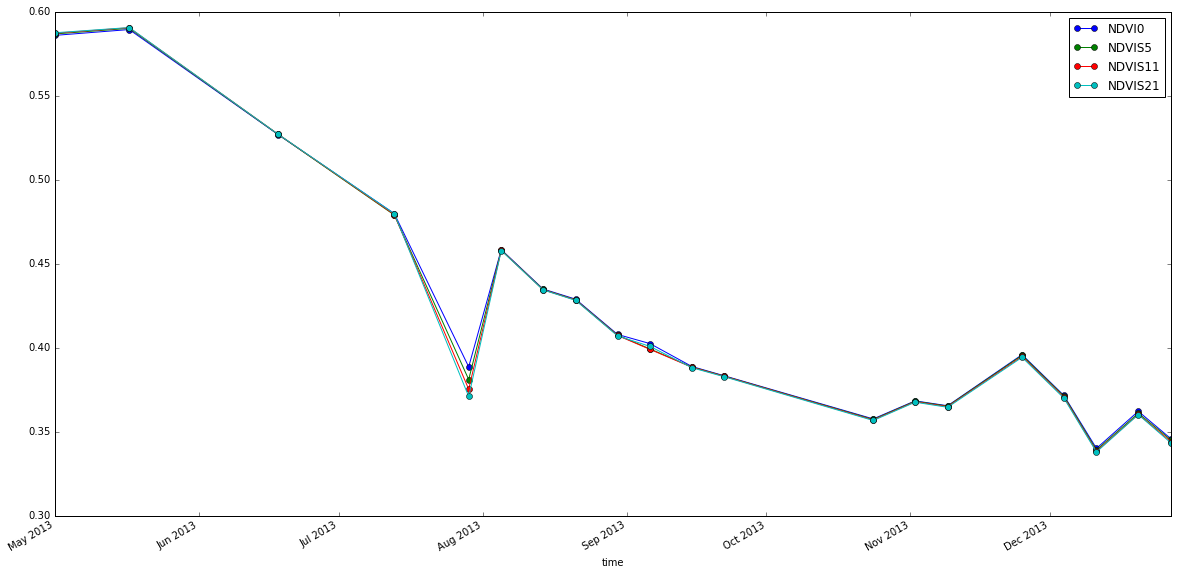

In [5]:
ndviobj = NDVI_Image_Stack()
ndviobj.main()


In [6]:
stop and review below
pick up useful codes

SyntaxError: invalid syntax (<ipython-input-6-b93ab9704721>, line 1)

In [ ]:
# Where?

# xp=(149.00, 149.20); yp=(-35.25, -35.35)  # Lake Burley Griffin x=(149.07, 149.17), y=(-35.25, -35.35), 
# xp=( 149.160,  149.170); yp=(-35.34 , -35.35 )  #a small area cover GA water pond


# Edge of fire scar (NT) 19:36:10.24S//132:34:55.72E
# 0.1degree =~ 10km 
# AOI_NAME='FireScarNT'; xp=(132.50, 132.60); yp=(-19.65, -19.55)

#Farming land (crops (green and fallow paddocks - Western NSW)30:5:45.33S/148:11:29.75E
#AOI_NAME='Farmland'; xp=(148.14, 148.24); yp=(-30.15, -30.05) # North of Dubbo, inside NSW border

#Woodland (greenish most of the time. the understory should change in response to seasonal drying out)22:52:35.4S/147:24:11.25E
AOI_NAME='Woodland'; xp=(147.35, 147.45); yp=(-22.92, -22.82)  # west of Rockhampton 
# woodland has a blank image in 2016-05? with NDVI=0. how to exclude it?
                
# When? a time range
tp=('1980-01-01', '2016-12-31')


#To see the function signature?
#dc.load?


In [ ]:
prod_type='ls5_nbar_albers'

pq_prod_type = prod_type.replace('nbar','pq')

good_ndvi=get_ndvi(prod_type, xp,yp,tp,cloudfreeRatio = 0.5)

print (good_ndvi.shape)

In [ ]:
good_ndvi[:20].plot(col='time', col_wrap=5, add_colorbar=False)

In [ ]:
img1=good_ndvi[7]
#mask = ~np.isnan(img1); img1f = median(img1,disk(5), mask=mask)
img1f = filter_center(img1, size=3, func=np.nanmedian )

In [ ]:
plt.imshow(img1f)


In [ ]:
plt.imshow(img1)

In [ ]:
np.nanmean(img1f)

In [ ]:
img1.mean()

In [ ]:

ndvi578.plot( figsize=(20,10),  marker='*' )

In [ ]:
#ndvi_mean

In [ ]:
outcsvfile='meanNDVI578_%s.csv'% (AOI_NAME)

ndvi578.to_csv(outcsvfile)  #('/tmp/meanNDVI578_FireScarNT.csv')

In [ ]:
ndvi578.hist(bins=100)

In [ ]:
p10= ndvi578.quantile(0.1)
p90= ndvi578.quantile(0.9)

bot_tenperc=ndvi578[(ndvi578['NDVI'] <= p10[0])].dropna()
top_tenperc=ndvi578[(ndvi578['NDVI'] >= p90[0])].dropna()

In [ ]:
outcsvfile2='meanNDVI578_%s_bot10pc.csv'% (AOI_NAME)
bot_tenperc.to_csv(outcsvfile2)

outcsvfile3='meanNDVI578_%s_top10pc.csv'% (AOI_NAME)
top_tenperc.to_csv(outcsvfile3)

In [ ]:
top_tenperc.head

In [ ]:
p10

In [ ]:
bot_tenperc.head(100)

In [ ]:
ndvidf21.plot(figsize=(20,10), marker='o' )

In [ ]:
stop


In [ ]:
#http://scikit-image.org/docs/stable/api/skimage.filters.html?highlight=local%20median%20filter

from skimage import data
from skimage.morphology import disk
from skimage.filters.rank import median
# >>> img = data.camera()
# >>> med = median(img, disk(5))

In [ ]:
def filtered_ndvi_mean(ndvi_imgs, ndisk=5):
    """ apply a spatial filter to the input ndvi_imgs array
    return a pandas dataframe of mean NDVI for the images.
    ndisk=5 is the default size of the disk filter
    See http://scikit-image.org/docs/stable/api/skimage.filters.html?highlight=local%20median%20filter
    """

    mydict={}
    for it in xrange(0, len(ndvi_imgs.time)):
        # apply median filter to get an image meds for this timeslice
        img=ndvi_imgs.isel(time=it)
        imask= ~np.isnan(img)
        meds = median(img,disk(ndisk), mask=imask)  
        #plt.imshow(meds)
        mydict.update({ndvi_imgs.time[it].values: meds.mean()})

    # convert mydict to pandas dataframe, with proper column names and index
    pdf=pandas.DataFrame(mydict.items(), columns=['Date', 'NDVI'])
    pdf.set_index('Date', inplace=True)
    
    return pdf

In [ ]:
scaled_good_ndvi = 128*(1+good_ndvi) # to unint8 or uint16 for scikit-image filter input

uint8_good_ndvi=scaled_good_ndvi.astype('uint8')

pdf5 = filtered_ndvi_mean( uint8_good_ndvi, ndisk=5)

pdf5.head()

In [ ]:
pdf0=filtered_ndvi_mean( uint8_good_ndvi, ndisk=0)

In [ ]:
# plt.figure( )
pdf0.plot(figsize=(20,10), marker='*' )

In [ ]:
pdf5.plot(figsize=(20,10), marker='*' )

In [ ]:
pdf10 = filtered_ndvi_mean( uint8_good_ndvi, ndisk=10)

print(pdf10.shape)
pdf10.plot(figsize=(20,10), marker='*' )

In [ ]:
pdf15 = filtered_ndvi_mean( uint8_good_ndvi, ndisk=15)

print(pdf15.shape)
pdf15.plot(figsize=(20,10), marker='*' )

In [ ]:
pdf20 = filtered_ndvi_mean( uint8_good_ndvi, ndisk=20)

print(pdf15.shape)
pdf20.plot(figsize=(20,10), marker='*' )

In [ ]:
# no filter, original ndvi images
ndvi578.sort_values('NDVI').head(40)

In [ ]:

for irow in xrange (0, pdf5.shape[0]):
    dtime=ndvi578.index[irow]
    print(dtime,ndvi578.iloc[irow][0], pdf5.iloc[irow].NDVI, pdf10.iloc[irow].NDVI, pdf15.iloc[irow].NDVI, pdf20.iloc[irow].NDVI)

In [ ]:
bot_tenperc.head()

In [ ]:
(147.901603-128)/128

In [ ]:
pdf15.sort_values('NDVI').head(40)

In [ ]:
top_tenperc.head(5)

In [ ]:
done

## Normalised Difference Water Index

In [ ]:
# images after removed invalid pixels. 
#ndwi.plot(col='time', col_wrap=6)


### Weed out the low quality images.

In [ ]:
# apply the cloud_threshold mask, which will select a subset images with good pixels. 

mostly_good_ndwi = ndwi.where(mostly_cloud_free).dropna('time', how='all')

mostly_good_ndwi.plot(col='time', col_wrap=5)

## Statistics Median and Mean Images

### Normalised Vegetation Index vs Water Index

In [ ]:
plt.figure( figsize=(16,12) )
    
plt.subplot( 2,2,1 )
mostly_good_ndvi.median(dim='time').plot()
plt.title("Median Normalised Difference Vegetation Index - NDVI"); plt.xlabel('easting'); plt.ylabel('northing')


plt.subplot( 2,2,2 )
mostly_good_ndvi.mean(dim='time').plot()
# ndvi.mean(dim='time').plot()
plt.title("Mean Normalised Difference Vegetation Index - NDVI"); plt.xlabel('easting'); plt.ylabel('northing')

#------------------------------
plt.subplot( 2,2,3 )
mostly_good_ndwi.median(dim='time').plot()
plt.title("Median Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')


plt.subplot( 2,2,4 )
mostly_good_ndwi.mean(dim='time').plot()
# ndwi.mean(dim='time').plot()
plt.title("Mean Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')

# Water Observation from Space

http://eos-test.ga.gov.au/geoserver/www/remote_scripts/WOfS_v1.6.htm
